In [2]:
import os
import sys

os.environ["JAVA_HOME"] = "JDK 8"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [4]:
# Create a Spark session
spark = SparkSession.builder.appName("day3_vis").getOrCreate()

25/02/08 13:36:34 WARN Utils: Your hostname, Mint-T470 resolves to a loopback address: 127.0.1.1; using 192.168.1.249 instead (on interface wlp4s0)
25/02/08 13:36:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/08 13:36:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/08 13:36:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
sns.set_theme(style="whitegrid")

In [6]:
titanic_pd = sns.load_dataset("titanic")
titanic_df = spark.createDataFrame(titanic_pd).dropna()
titanic_df.show()


+--------+------+------+----+-----+-----+-------+--------+------+-----+----------+----+-----------+-----+-----+
|survived|pclass|   sex| age|sibsp|parch|   fare|embarked| class|  who|adult_male|deck|embark_town|alive|alone|
+--------+------+------+----+-----+-----+-------+--------+------+-----+----------+----+-----------+-----+-----+
|       0|     3|  male|22.0|    1|    0|   7.25|       S| Third|  man|      true| NaN|Southampton|   no|false|
|       1|     1|female|38.0|    1|    0|71.2833|       C| First|woman|     false|   C|  Cherbourg|  yes|false|
|       1|     3|female|26.0|    0|    0|  7.925|       S| Third|woman|     false| NaN|Southampton|  yes| true|
|       1|     1|female|35.0|    1|    0|   53.1|       S| First|woman|     false|   C|Southampton|  yes|false|
|       0|     3|  male|35.0|    0|    0|   8.05|       S| Third|  man|      true| NaN|Southampton|   no| true|
|       0|     1|  male|54.0|    0|    0|51.8625|       S| First|  man|      true|   E|Southampton|   no

In [7]:
class_survival = titanic_df.groupBy("class").sum("survived").toPandas()

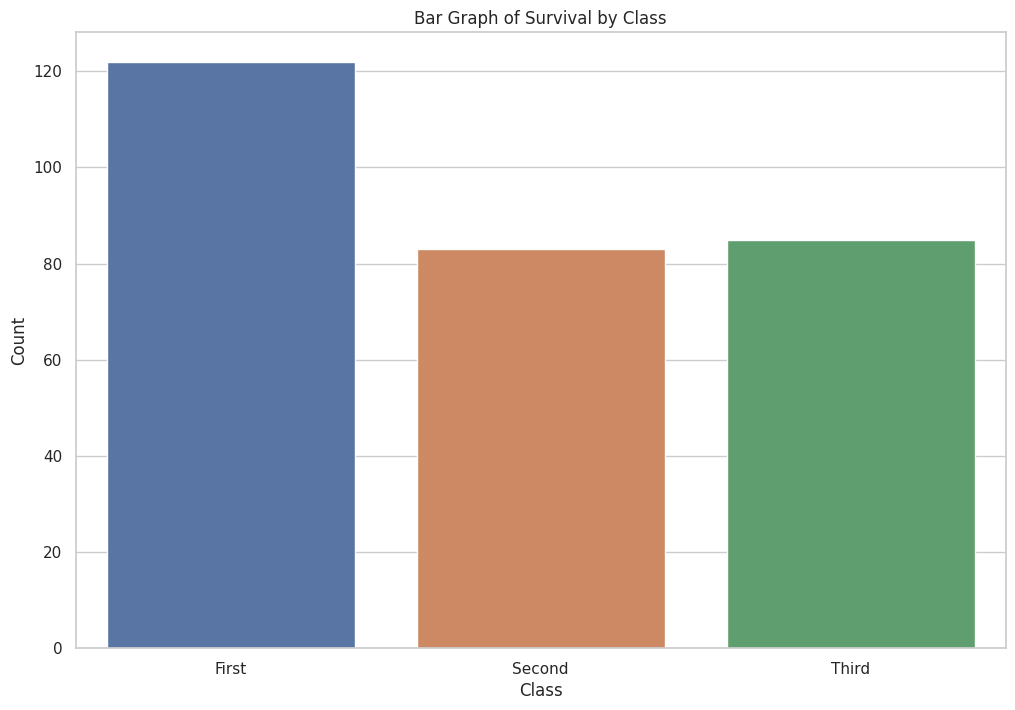

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(data=class_survival, x = "class", y = "sum(survived)", hue="class")

plt.title("Bar Graph of Survival by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [9]:
survival_class = titanic_df.groupBy("class", "survived").count().toPandas()
survival_class

,class,survived,count
0,Second,1,83
1,First,0,64
2,Second,0,90
3,Third,0,270
4,First,1,122
5,Third,1,85


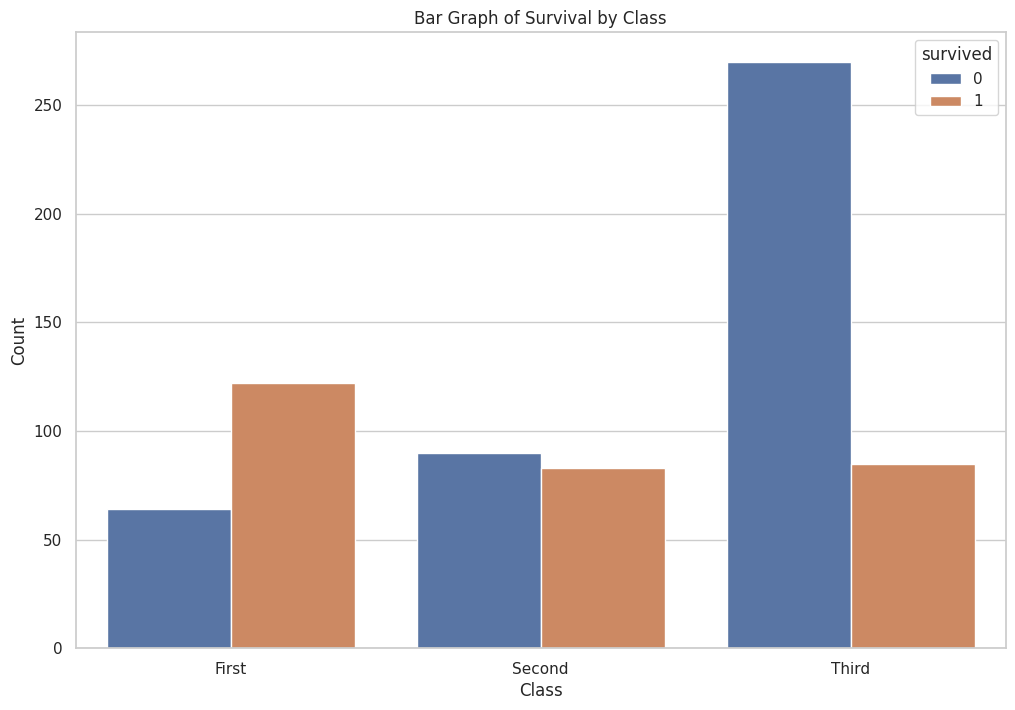

In [10]:
plt.figure(figsize=(12,8))
sns.barplot(data=survival_class, x = "class", order = ["First", "Second", "Third"], y = "count", hue="survived")
plt.title("Bar Graph of Survival by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

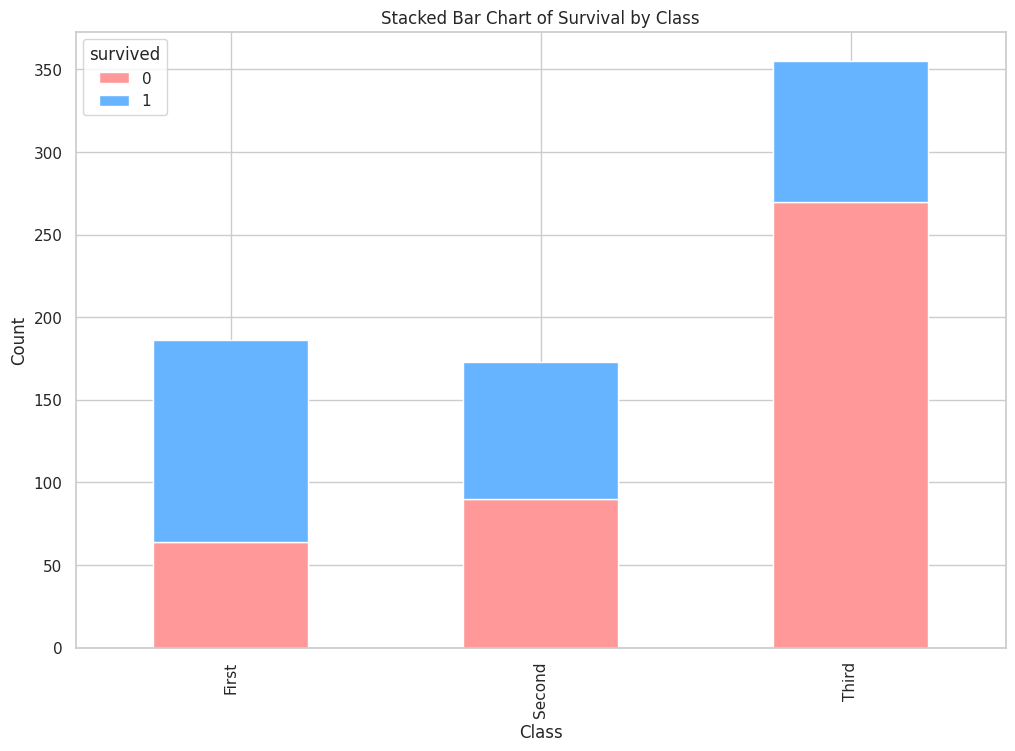

In [11]:
# Pivot the data to make a separate column for each 'survived' category
pivot_data = survival_class.pivot_table(index='class', columns='survived', values='count')

# Create a stacked bar plot
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#ff9999', '#66b3ff'])

# Adding titles and labels
plt.title("Stacked Bar Chart of Survival by Class")
plt.xlabel("Class")
plt.ylabel("Count")

# Show plot
plt.show()

In [12]:
avg_age_stats = titanic_df.groupBy("class", "sex").agg(round(avg("age"), 2).alias("avg_age")).toPandas()
avg_age_stats

,class,sex,avg_age
0,Third,female,21.75
1,First,male,41.28
2,First,female,34.61
3,Second,female,28.72
4,Second,male,30.74
5,Third,male,26.51


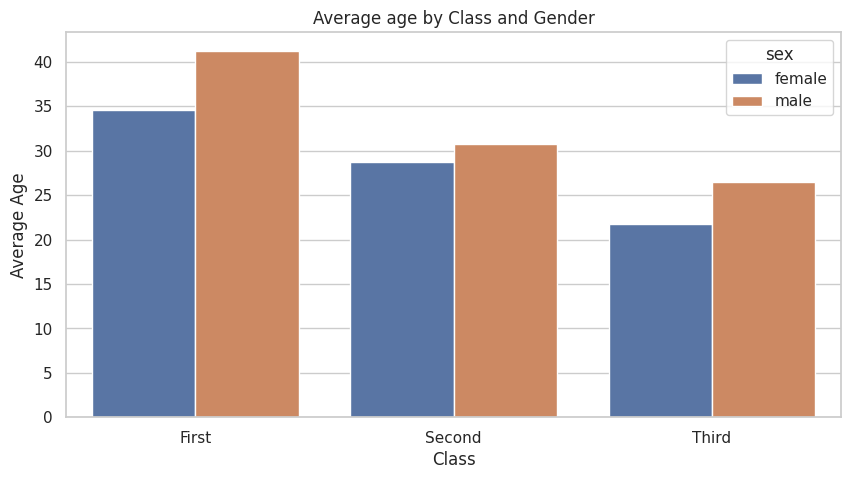

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(data=avg_age_stats, x="class", y="avg_age", order= ("First", "Second", "Third"), hue="sex")
plt.title("Average age by Class and Gender")
plt.xlabel("Class")
plt.ylabel("Average Age")
plt.show()

In [14]:
fares_class = titanic_df.groupBy("class").agg(round(avg("fare"), 2).alias("avg_fare")).toPandas()
fares_class


,class,avg_fare
0,First,87.96
1,Second,21.47
2,Third,13.23


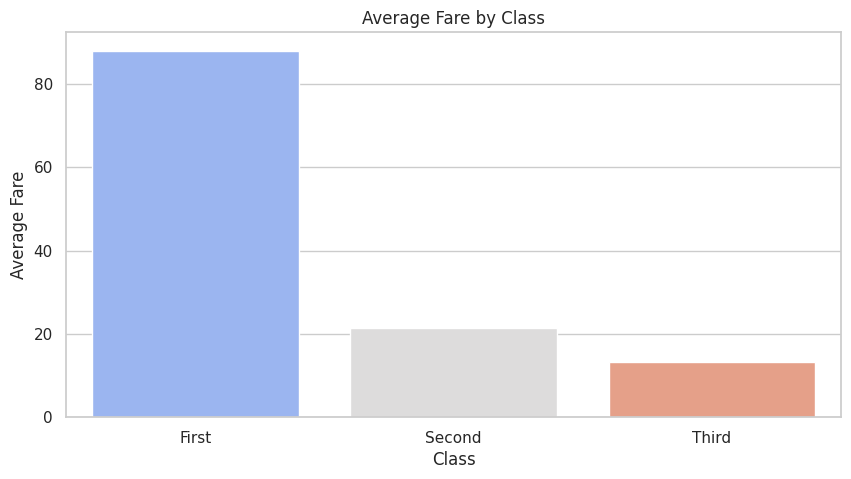

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(data=fares_class, x="class", y="avg_fare", order= ("First", "Second", "Third"), hue="class", palette="coolwarm")
plt.title("Average Fare by Class")
plt.xlabel("Class")
plt.ylabel("Average Fare")
plt.show()

In [16]:
num_columns = ["survived", "pclass", "fare", "age"]
titanic_numeric = titanic_df.select(num_columns)
correlation = titanic_numeric.toPandas().corr()
correlation

,survived,pclass,fare,age
survived,1.000000,-0.359653,0.268189,-0.077221
pclass,-0.359653,1.000000,-0.554182,-0.369226
fare,0.268189,-0.554182,1.000000,0.096067
age,-0.077221,-0.369226,0.096067,1.000000


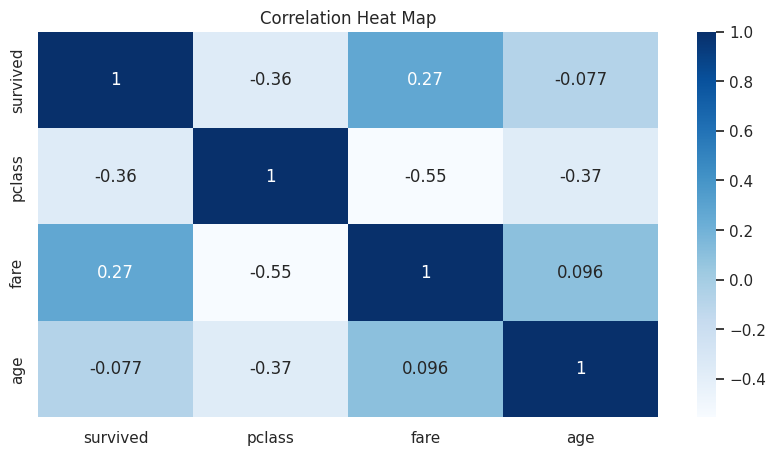

In [17]:
plt.figure(figsize=(10,5))
sns.heatmap(data=correlation, annot=True, cmap="Blues")
plt.title("Correlation Heat Map")
plt.show()

/home/yuri/Documents/Data Engineering/vis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yuri/Documents/Data Engineering/vis/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


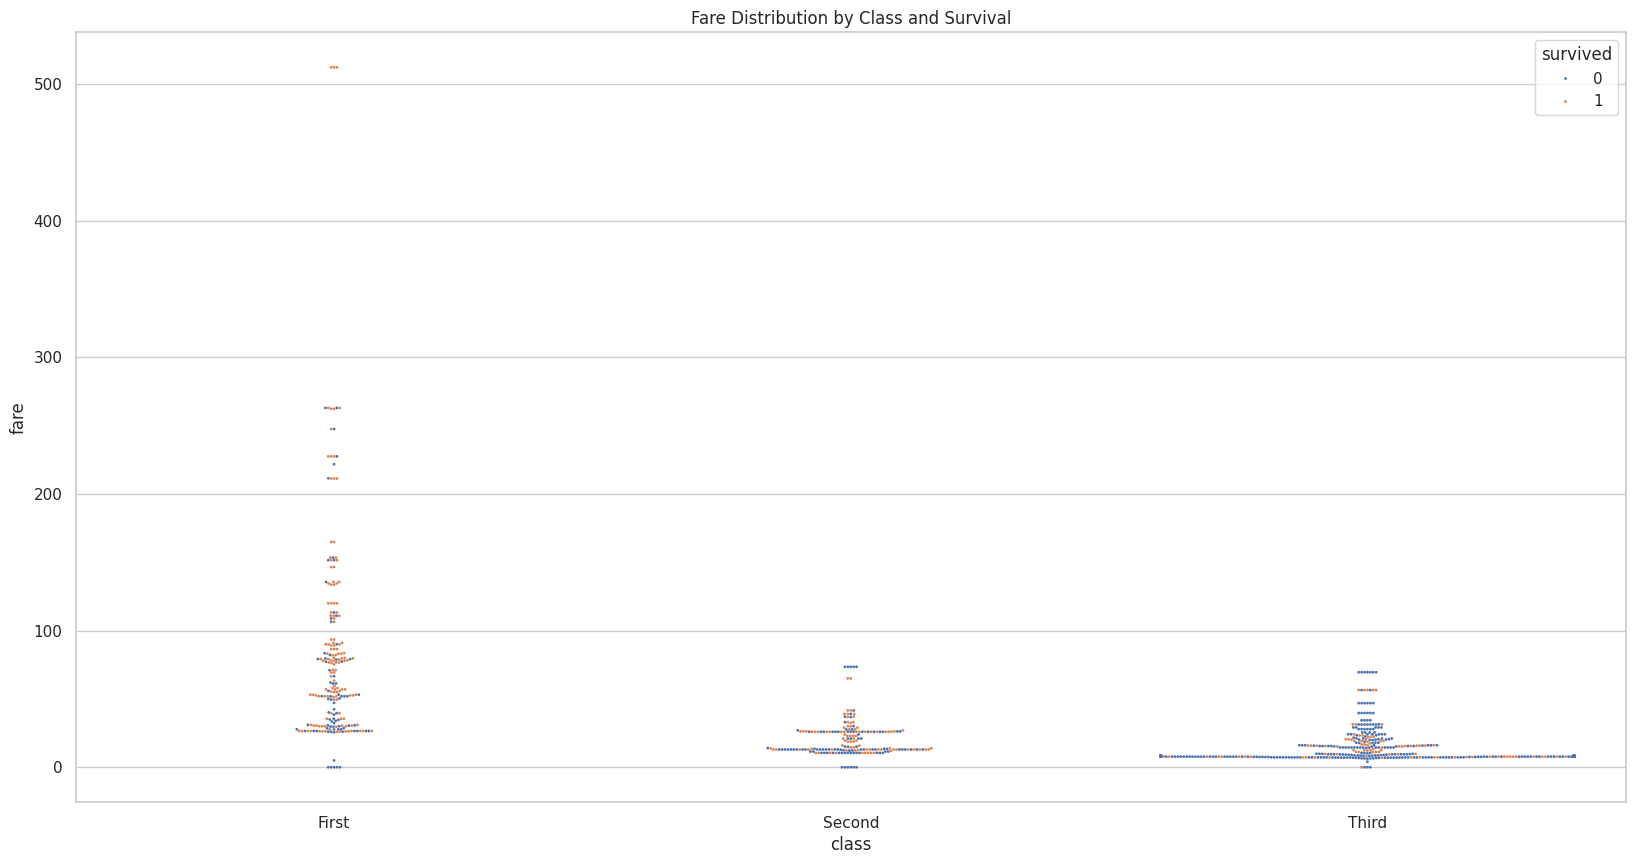

In [ ]:
plt.figure(figsize=(20,10))
sns.swarmplot(data=titanic_pd, x="class", y="fare", hue="survived", s=2)
plt.title("Fare Distribution by Class and Survival")
plt.show()

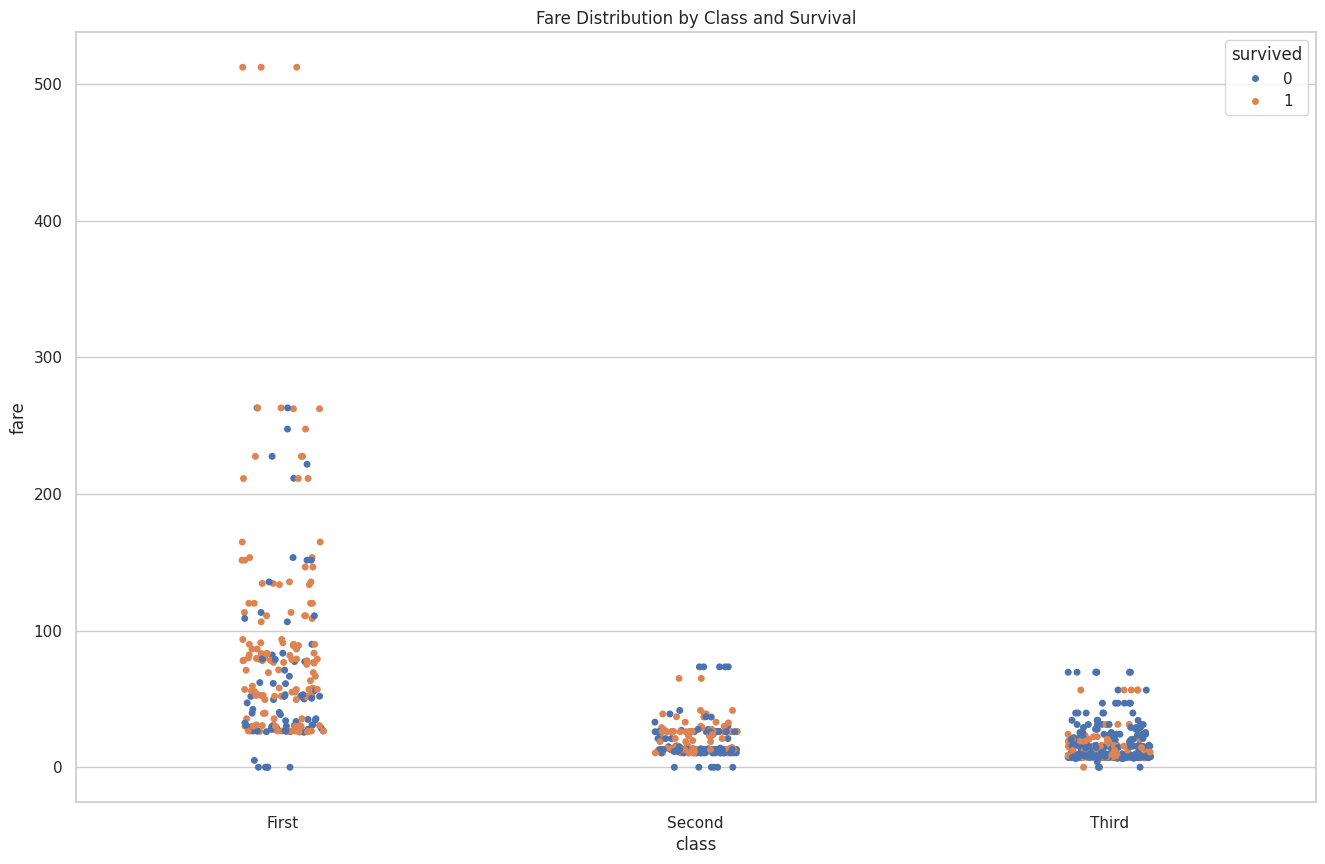

In [32]:
plt.figure(figsize=(16,10))
sns.stripplot(data=titanic_pd, x="class", y="fare", hue="survived", jitter=True)
plt.title("Fare Distribution by Class and Survival")
plt.show()

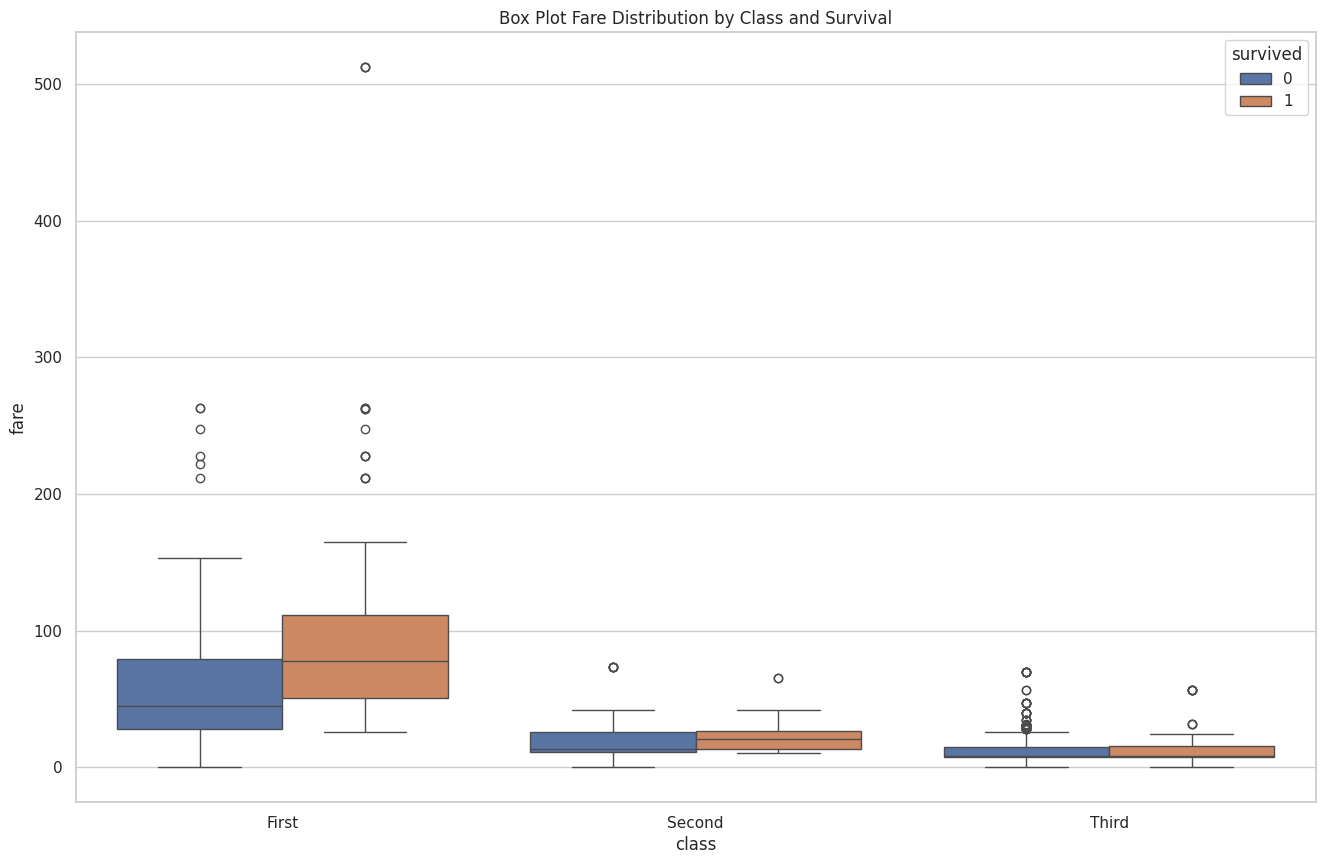

In [36]:
plt.figure(figsize=(16,10))
sns.boxplot(data=titanic_pd, x="class", y="fare", hue="survived")
plt.title("Box Plot Fare Distribution by Class and Survival")
plt.show()

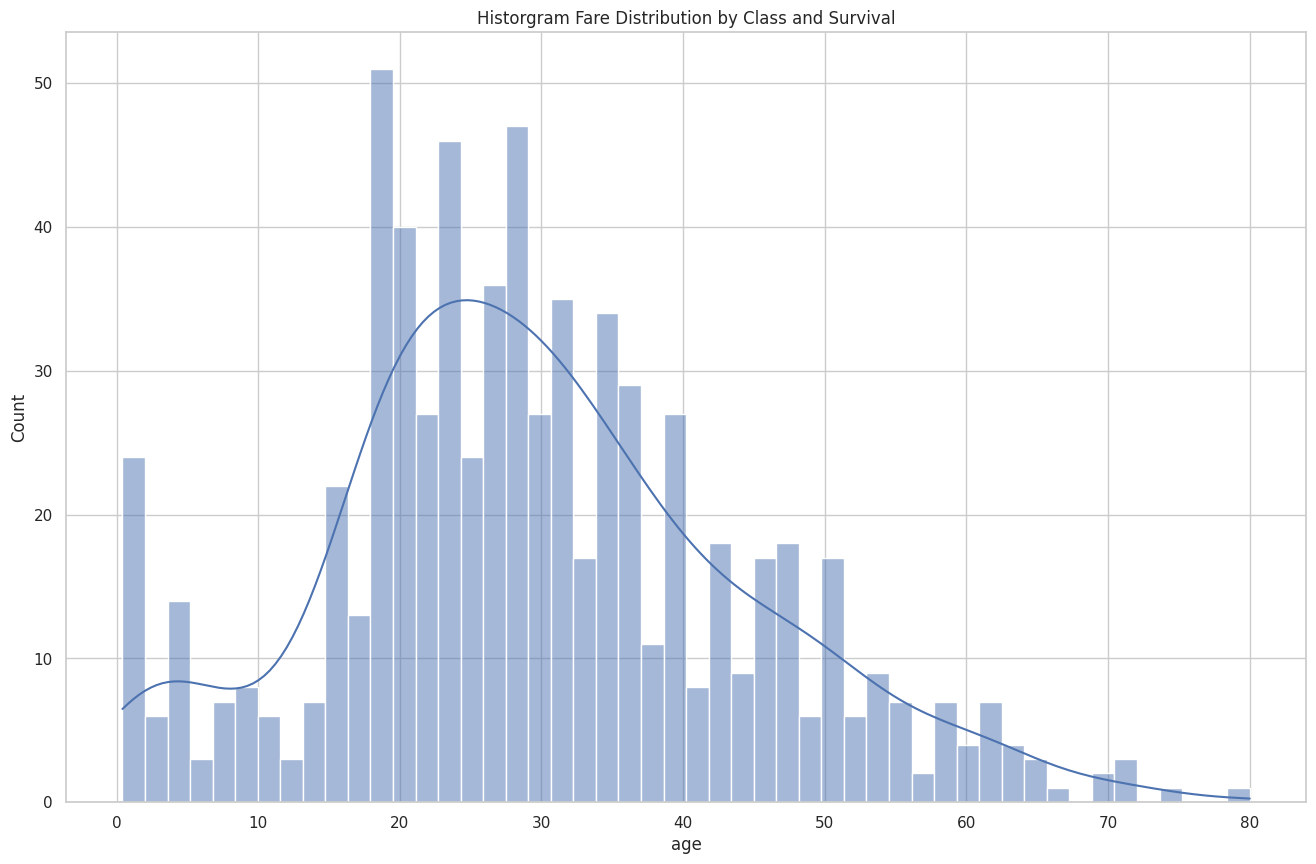

In [44]:
plt.figure(figsize=(16,10))
sns.histplot(titanic_pd["age"].dropna(), kde=True, bins=50)
plt.title("Historgram Fare Distribution by Class and Survival")
plt.show()

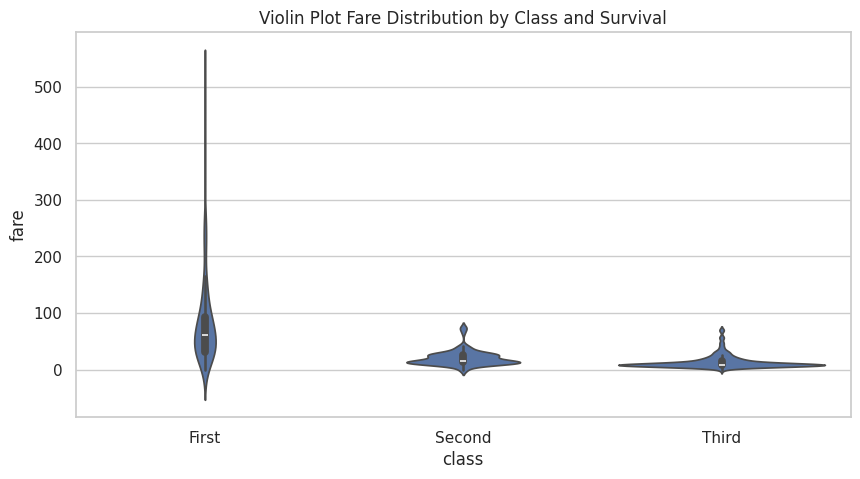

In [51]:
plt.figure(figsize=(10,5))
sns.violinplot(data=titanic_pd, x="class", y="fare") # hue="survived")
plt.title("Violin Plot Fare Distribution by Class and Survival")
plt.show()

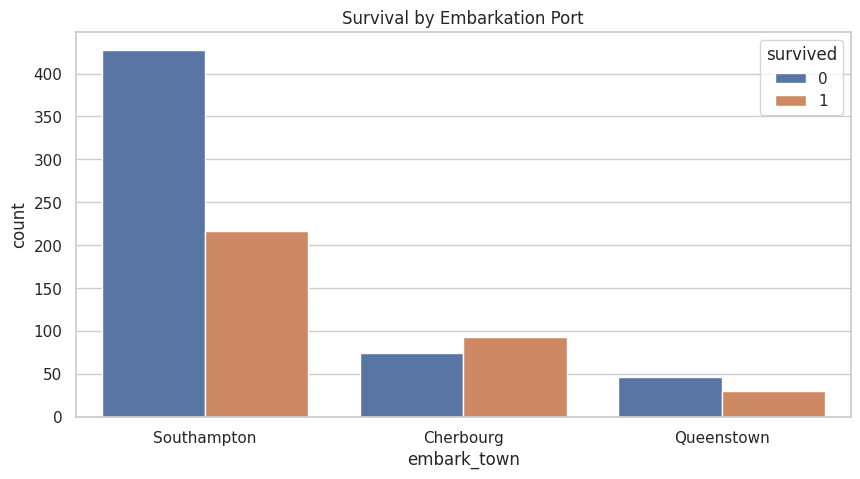

In [52]:
plt.figure(figsize=(10, 5))
sns.countplot(data=titanic_pd, x='embark_town', hue='survived')
plt.title("Survival by Embarkation Port")
plt.show()

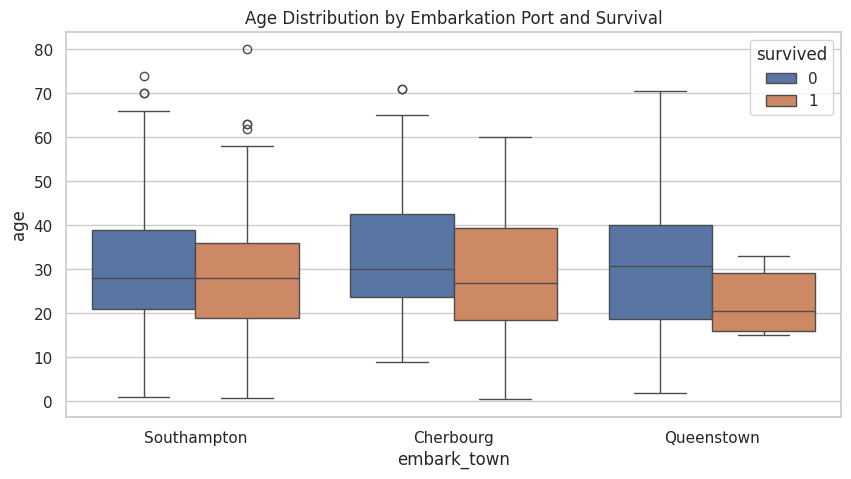

In [53]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=titanic_pd, x='embark_town', y='age', hue='survived')
plt.title("Age Distribution by Embarkation Port and Survival")
plt.show()

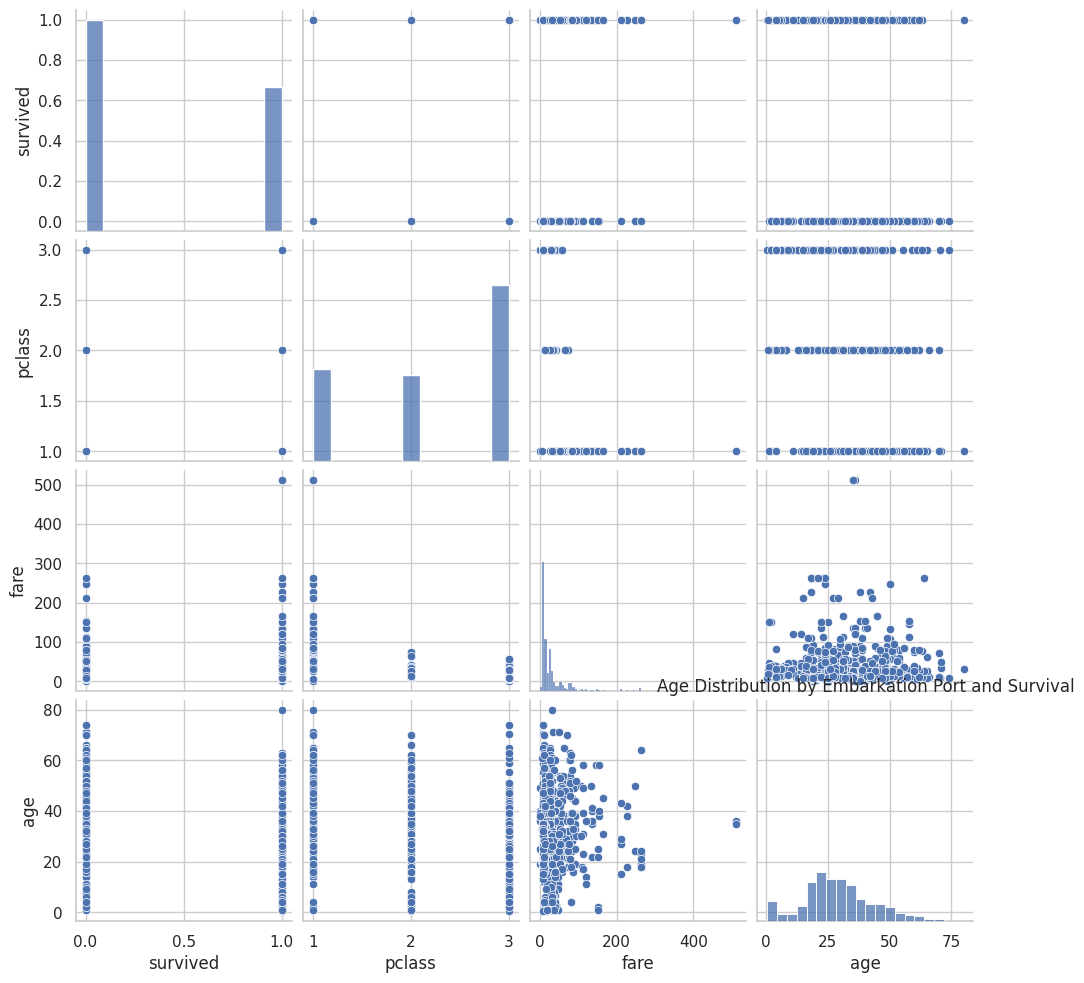

In [56]:
# plt.figure(figsize=(10, 5))
sns.pairplot(titanic_numeric.toPandas())
plt.title("Age Distribution by Embarkation Port and Survival")
plt.show()

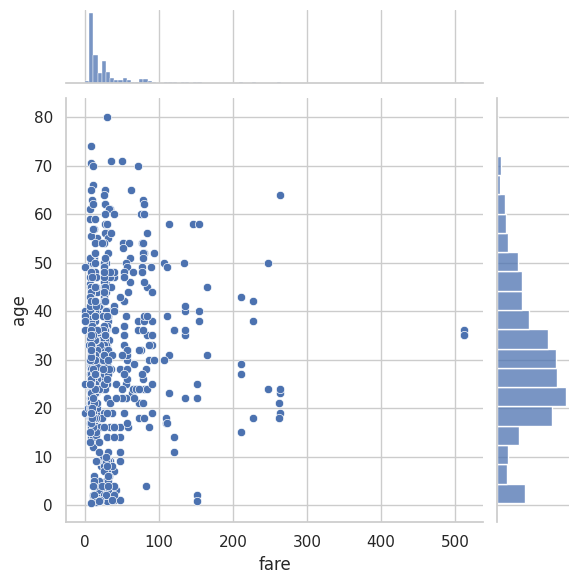

In [61]:
sns.jointplot(data=titanic_numeric.toPandas(), x="fare", y="age", kind="scatter")

In [86]:
# Sampling large datasets
import numpy as np

rdd = spark.sparkContext.parallelize((i, np.random.randn()) for i in range(100000))
pyspark_df = rdd.toDF(["index", "value"])
pyspark_df.show(5)

+-----+-------------------+
|index|              value|
+-----+-------------------+
|    0|-2.3379424350340416|
|    1|-0.4724076088487198|
|    2|  1.086976913840096|
|    3| 0.9613346173613202|
|    4| 0.6797466808511304|
+-----+-------------------+
only showing top 5 rows



In [87]:
sampled_df = pyspark_df.sample(fraction=0.01)
sampled_df


DataFrame[index: bigint, value: double]

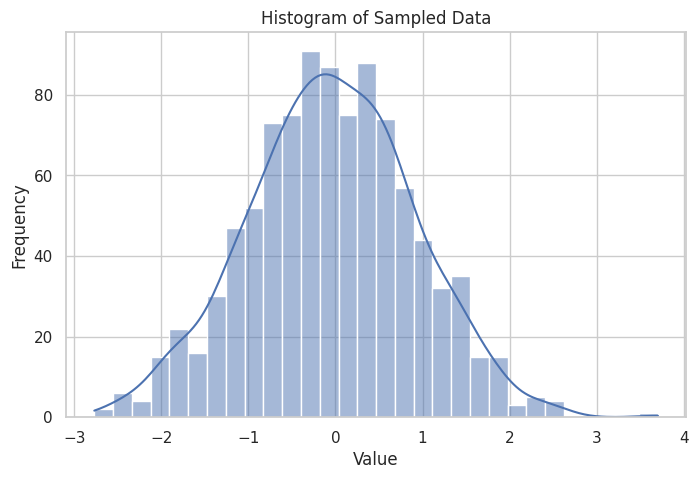

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(sampled_df.toPandas(), x="value", bins=30, kde=True)

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Sampled Data")

plt.show()

In [104]:
agg_df = pyspark_df.groupBy(expr('FLOOR(value * 10) / 10 AS bin_value')).agg(count('value')).alias('count')
agg_df = agg_df.orderBy('bin_value', ascending=False).toPandas()

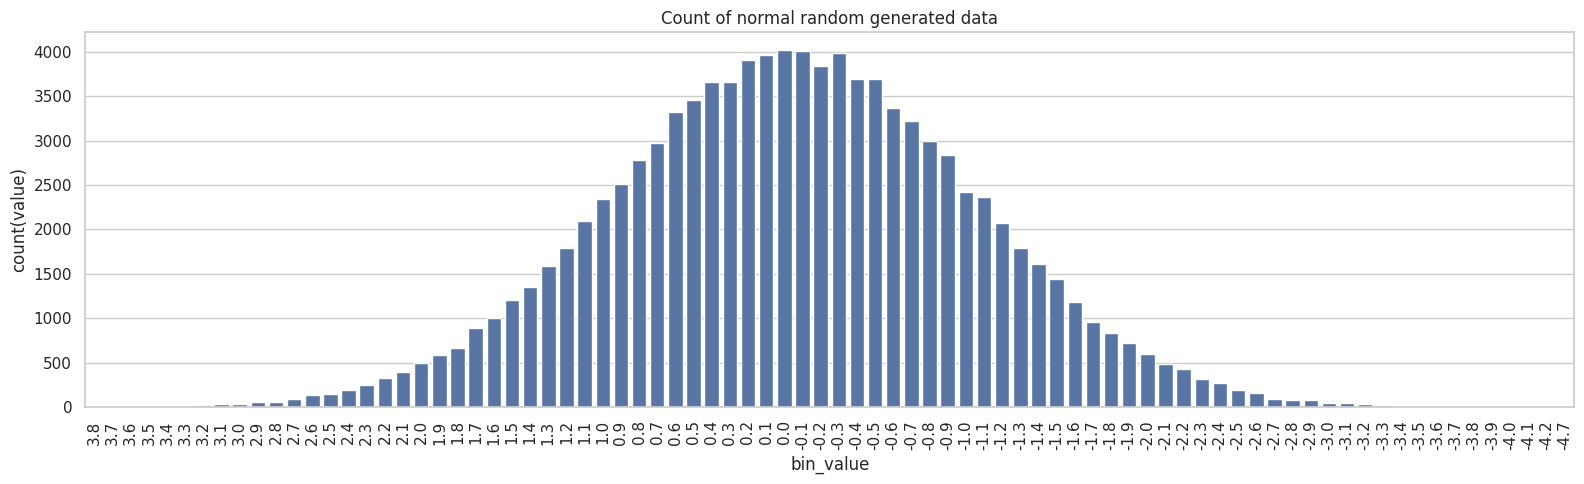

In [106]:
plt.figure(figsize=(16, 5))
sns.barplot(x=agg_df['bin_value'].astype(str), y=agg_df['count(value)'])
plt.title('Count of normal random generated data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Time series of COVID-19 Cases
#### Heatmaps of new cases (think by month and local authority)
#### cumulative case / death rates
#### distribution of cases accross all local authorities (hist)

In [110]:
covid_data = "UK_Local_Authority_UTLA_COVID_Dataset.csv"
covid_df = spark.read.csv(covid_data, header=True, inferSchema=True)
covid_pd = covid_df.toPandas()

In [138]:
# # plt.figure(figsize=(10, 5))
# sns.pairplot(covid_pd, hue="areaName")
# plt.show()

In [142]:
total_cases = covid_df.groupBy("areaName").agg(sum("cumCasesByPublishDate").alias("total_cumli_case"))\
    .orderBy(desc("total_cumli_case")).limit(5).toPandas()

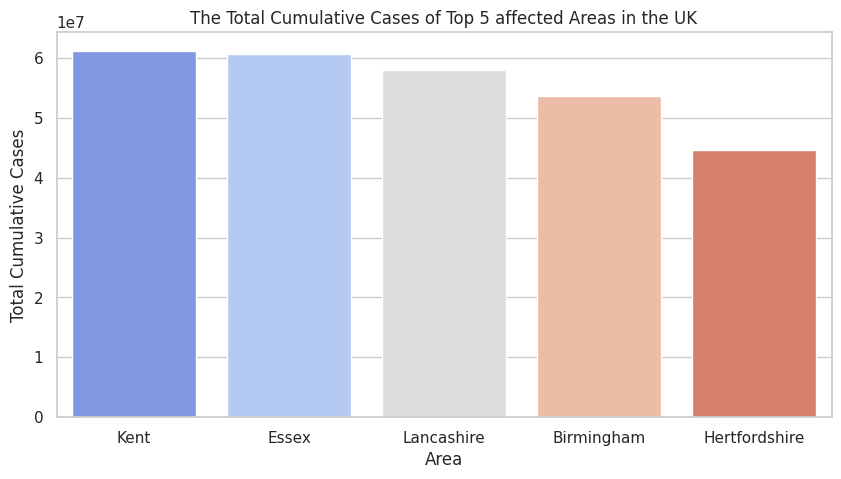

In [147]:
plt.figure(figsize=(10,5))
sns.barplot(data=total_cases, x="areaName", y="total_cumli_case", hue="areaName", palette="coolwarm")
plt.title("The Total Cumulative Cases of Top 5 affected Areas in the UK")
plt.xlabel("Area")
plt.ylabel("Total Cumulative Cases")
# plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()
